Let's do some GIS with Python!

# The GIS stack in Python 

* fiona
* shapely
* pyproj
* geopandas 
* rtree (spatial indexing)
* geoplot (for plotting)

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pylab as plt
import geoplot as gplt
import geoplot.crs as gcrs
import seaborn as sns
import fiona
import io
import requests
%matplotlib inline

In [2]:
%load_ext watermark

In [3]:
%watermark -d -z -v -p geopandas,shapely,fiona,pyproj,geoplot -g -h -m -w

2017-03-23 CET

CPython 3.5.2
IPython 5.3.0

geopandas 0.2.1
shapely 1.5.17
fiona 1.7.5
pyproj 1.9.5.1
geoplot n

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)
system     : Darwin
release    : 16.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
host name  : MacBook-Pro-de-Qucit.local
Git hash   : 8f5a23e87f059a1b3720f8e3a9cb719ceefe968a
watermark 1.3.4


# Import Airport data

* Flights data source
* http://openflights.org/data.html

In [4]:
column_names = ['id', 'name', 'city', 'country', 'IATA', 'ICAO', 'latitude', 'longitude', 'altitude', 'timezone', 
                'dst', 'tz_database_time_zone', 'type', 'source']

In [5]:
airports_url="https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
airports_df = pd.read_csv(airports_url, header=None, names=column_names)

In [7]:
airports_df.describe()

,id,latitude,longitude,altitude
count,7184.000000,7184.000000,7184.000000,7184.000000
mean,4672.248886,25.950874,-2.946702,1011.833101
std,3324.796152,28.239954,85.993653,1608.349308
min,1.000000,-90.000000,-179.876999,-1266.000000
25%,1853.750000,7.366353,-79.467924,66.000000
50%,3809.500000,34.262400,5.820455,354.000000
75%,7187.250000,47.290104,50.838224,1197.250000
max,12057.000000,82.517799,179.951004,14219.000000


In [6]:
airports_df.head()

,id,name,city,country,IATA,ICAO,latitude,longitude,altitude,timezone,dst,tz_database_time_zone,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


# Transform Pandas DataFrame into a GeoPandas DataFrame

In [8]:
def longitude_latitude_to_geom(row):
    p = Point(row['longitude'], row['latitude'], row['altitude'])
    return p
def add_geometry_column(input_df):
    df = input_df.copy()
    return df.assign(geometry=lambda df: df.apply(longitude_latitude_to_geom, axis=1))
def create_gdf_from_df(input_df):
    df = input_df.copy()
    return (df.pipe(add_geometry_column)
              .drop(['longitude', 'latitude', 'altitude'], axis=1)
              .pipe(gpd.GeoDataFrame))

In [9]:
airports_gdf = airports_df.pipe(create_gdf_from_df)

In [10]:
airports_gdf.head()

,id,name,city,country,IATA,ICAO,timezone,dst,tz_database_time_zone,type,source,geometry
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,10,U,Pacific/Port_Moresby,airport,OurAirports,POINT Z (145.391998291 -6.081689834590001 5282)
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,10,U,Pacific/Port_Moresby,airport,OurAirports,POINT Z (145.789001465 -5.20707988739 20)
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,10,U,Pacific/Port_Moresby,airport,OurAirports,POINT Z (144.2960052490234 -5.826789855957031 ...
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,10,U,Pacific/Port_Moresby,airport,OurAirports,POINT Z (146.725977 -6.569803 239)
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,10,U,Pacific/Port_Moresby,airport,OurAirports,POINT Z (147.2200012207031 -9.443380355834961 ...


# Find airports in France

## Read France shapes

The data is extracted from here: https://github.com/gregoiredavid/france-geojson

In [11]:
FRANCE_DEPARTMENT_URL = 'https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson'

In [12]:
request = requests.get(FRANCE_DEPARTMENT_URL)
b = bytes(request.content)
with fiona.BytesCollection(b) as f:
    crs = f.crs
    france_gdf = gpd.GeoDataFrame.from_features(f, crs=crs)

In [13]:
france_gdf.head()

,code,geometry,nom
0,02,"POLYGON ((3.172704445659 50.011996744997, 3.18...",Aisne
1,10,"POLYGON ((3.4147888224632 48.390268550005, 3.4...",Aube
2,14,"POLYGON ((-1.1196198636379 49.355568981262, -1...",Calvados
3,15,"POLYGON ((2.5084125130653 45.478501516921, 2.5...",Cantal
4,28,"POLYGON ((0.8148247207739 48.670163564137, 0.8...",Eure-et-Loir


## Plot France shapes

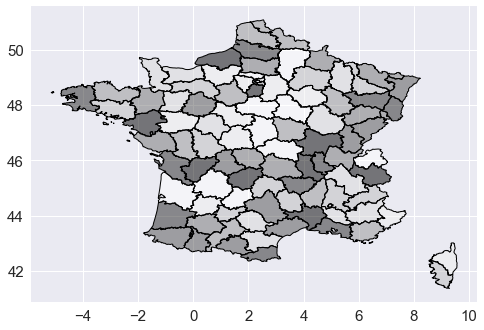

In [35]:
france_gdf.plot()

=> Deformed map

In [18]:
france_gdf.to_crs({'init': 'epsg:cea'}).plot()

RuntimeError: b"no options found in 'init' file"

In [22]:
france_gdf

,code,geometry,nom
0,02,"POLYGON ((3.172704445659 50.011996744997, 3.18...",Aisne
1,10,"POLYGON ((3.4147888224632 48.390268550005, 3.4...",Aube
2,14,"POLYGON ((-1.1196198636379 49.355568981262, -1...",Calvados
3,15,"POLYGON ((2.5084125130653 45.478501516921, 2.5...",Cantal
4,28,"POLYGON ((0.8148247207739 48.670163564137, 0.8...",Eure-et-Loir
5,35,"(POLYGON ((-2.0068973832739 48.566110094782, -...",Ille-et-Vilaine
6,39,"POLYGON ((5.5185372800929 47.304183948833, 5.5...",Jura
7,40,"POLYGON ((-1.253891222702 44.4676023661, -1.19...",Landes
8,42,"POLYGON ((3.899538631706 46.275908099459, 3.90...",Loire
9,45,"POLYGON ((1.9940901445311 48.286584124472, 2.0...",Loiret


In [37]:
proj = gcrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5)

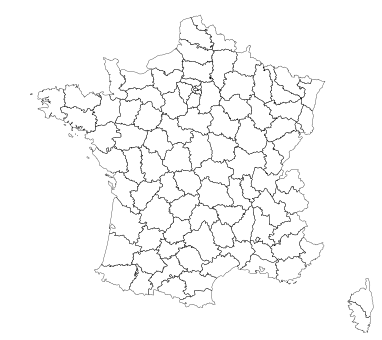

In [39]:
ax = gplt.polyplot(france_gdf, projection=gcrs.Orthographic())

### Select France Airports